In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time

## For computers with no GPU. Remove if GPU is present.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Step 1: Data Preprocessing.

The first step in our fitting process will consist of reading all of the data contained in the "Tobacco3482-jpg/" directory, and putting it into appropriate format to be analyzed by our neural network. In summary, the steps are:

1. To obtain the names of the different classes, and the names of the images inside of "Tobacco3482-jpg/."
2. To import all images of interest into python, and resize them to fit the 227x227x3 input of AlexNet. Also eliminate corrupted observations.
3. Divide the images/labels into training, testing and validating datasets.
4. Put the images and labels into a format that TensorFlow manages easily: tensorflow.data.dataset.

Each chunk is a step that contributes to one of these tasks. They are commented for better understanding.

In [12]:
## Folder names inside our data directory
dataset_path = os.listdir("/data/dssg/occrp/data/input/tobacco_dataset/")
print("The folders inside the Tobacco3482 directory are:", dataset_path)

## Different document classes in our data directory.
CLASS_NAMES = os.listdir("/data/dssg/occrp/data/input/tobacco_dataset/")
print("The classes to be considered by our classifier are: ", CLASS_NAMES)

print("Types of documents found:", len(CLASS_NAMES))

The folders inside the Tobacco3482 directory are: ['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
The classes to be considered by our classifier are:  ['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
Types of documents found: 10


In [13]:
## Here, we obtain a list of all of the filenames inside
## the subdirectories of the "Tobacco3482-jpg/" directory.
docs = []
# Get all file types
for item in CLASS_NAMES:
    all_docs = os.listdir("/data/dssg/occrp/data/input/tobacco_dataset/" + item)

    # Add them to the list:
    for doc in all_docs:
        docs.append((item, str("/data/dssg/occrp/data/input/tobacco_dataset/" + item) + "/" + doc))

# print(docs)
# docs

In [14]:
# Build a dataframe:
## Two columns: document type and file directory.
docs_df = pd.DataFrame(data=docs, columns=["doc type", "image"])
print(docs_df.head())
print("Total number of scanned pages in the dataset:", len(docs_df))

## We count how many images correspond to each
## document type.
doc_count = docs_df["doc type"].value_counts()

## We print the results.
print("Rooms in each category:")
print(doc_count)

  doc type                                              image
0     ADVE  /data/dssg/occrp/data/input/tobacco_dataset/AD...
1     ADVE  /data/dssg/occrp/data/input/tobacco_dataset/AD...
2     ADVE  /data/dssg/occrp/data/input/tobacco_dataset/AD...
3     ADVE  /data/dssg/occrp/data/input/tobacco_dataset/AD...
4     ADVE  /data/dssg/occrp/data/input/tobacco_dataset/AD...
Total number of scanned pages in the dataset: 3492
Rooms in each category:
Memo          621
Email         600
Letter        568
Form          432
Report        266
Scientific    262
ADVE          231
Note          202
News          189
Resume        121
Name: doc type, dtype: int64


In [16]:
## This chunk of code extracts all document images from the folder
## and rezises them to fit the AlexNet imput of 227x227x3.

path = "/data/dssg/occrp/data/input/tobacco_dataset/"
im_size = 227

images = []
labels = []
type_counter = 0
file_counter = 0
faulty = []


## In this loop, we extract all document images,
## and resize them to 227x227x3 (color image)
for i in CLASS_NAMES:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)]
    for f in filenames:
        img = cv2.imread(os.path.join(data_path, f))  # reading image as array
        v_type = type(img)
        if v_type is np.ndarray:
            # print(f," : ", img.shape[0], " x ", img.shape[1])
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(i)

        ## Save the positions of damaged files:
        if v_type is not np.ndarray:
            type_counter = type_counter + 1
            faulty.append(file_counter)
            # print( "Faulty file!")
        file_counter = file_counter + 1


print("There are a total of ", type_counter, " faulty files.")

There are a total of  10  faulty files.


In [17]:
## We convert images into a np.darray:
images = np.array(images)
print("Size of image tensor is:", images.shape)

## We resize the np.darray entries to be between 0 and 1.
images = images.astype("float32") / 255.0

Size of image tensor is: (3482, 227, 227, 3)


In [18]:
## Eliminate damaged files from database.
print("The original size of our database is:", docs_df.shape)
print("We want to eliminate the rows: ", faulty)
docs_df = docs_df.drop(labels=faulty, axis=0)
# docs_df2 = docs_df.reindex(axis=0)
print("The new dimensions are:", docs_df.shape)

The original size of our database is: (3492, 2)
We want to eliminate the rows:  [225, 830, 1262, 1781, 2428, 2640, 2842, 3070, 3229, 3491]
The new dimensions are: (3482, 2)


In [19]:
## To train the CNN, we need to encode our response as
## an numerical and in array shape. Here, we do this with
## labelEncoder.
y = docs_df["doc type"].values
print(y[:5])

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y[:5])

y = y.reshape(-1, 1)
print(y)

['ADVE' 'ADVE' 'ADVE' 'ADVE' 'ADVE']
[0 0 0 0 0]
[[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]


In [20]:
## We permute our data, to extract random subsets of data from it.
images_shuffle, y_shuffle = shuffle(images, y, random_state=5)

## We divide our data into training, testing and validating sets.
##      400 test observations.
##      400 validation observations.
##      2682 training observations.
train_images, train_labels = images_shuffle[800:], y_shuffle[800:]
test_images, test_labels = images_shuffle[400:800], y_shuffle[400:800]
validation_images, validation_labels = images_shuffle[0:400], y_shuffle[0:400]

## We save them as tf.datasets for convenience.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

2022-07-14 16:09:25.428034: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-14 16:09:25.428085: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: dssg01.semla.dfki.dev
2022-07-14 16:09:25.428095: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: dssg01.semla.dfki.dev
2022-07-14 16:09:25.428237: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-07-14 16:09:25.428260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-07-14 16:09:25.428266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.47.3
2022-07-14 16:09:25.428660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the foll

In [21]:
## We define image standarization function.
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    return image, label


train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 2682
Test data size: 400
Validation data size: 400


In [22]:
## We standardize, shuffle and batch our datasets.
train_ds = train_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=16, drop_remainder=True)

test_ds = test_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=16, drop_remainder=True)

validation_ds = (
    validation_ds.map(process_images).shuffle(buffer_size=train_ds_size).batch(batch_size=16, drop_remainder=True)
)

## Step 2: Model Fitting.

In the following chuncks, our goal is to define the AlexNet architecture, fit the model with the training data, and evaluate it on new data. In summary,

1. We define a function that creates and initializes the AlexNet architecture. This can be called at any time we want to create a new AlexNet model.
2. We define a callback that allows us to monitor the evolving of the accuracy of the model as the training unfolds. 
3. We define a callback that allows us to save the weights of a fitted model. This way, we can recover the trained model by accessing saved files.
4. We compare training, testing and validating accuracy. 

To observe the partial fitting results during training, just go to terminal, and run the command line:
tensorboard --logdir logstensorboard --logdir **saving directory** --bind_all

In [23]:
## When called, this function defines and compiles
## a CNN with AlexNet architecture.
def create_model():
    model = keras.models.Sequential(
        [
            keras.layers.Conv2D(
                filters=96,
                kernel_size=(11, 11),
                strides=(4, 4),
                activation="relu",
                input_shape=(227, 227, 3),
            ),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
            keras.layers.Conv2D(
                filters=256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation="relu",
                padding="same",
            ),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
            keras.layers.Conv2D(
                filters=384,
                kernel_size=(3, 3),
                strides=(1, 1),
                activation="relu",
                padding="same",
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=384,
                kernel_size=(3, 3),
                strides=(1, 1),
                activation="relu",
                padding="same",
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=256,
                kernel_size=(3, 3),
                strides=(1, 1),
                activation="relu",
                padding="same",
            ),
            keras.layers.BatchNormalization(),
            keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(4096, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(4096, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        metrics=["accuracy"],
    )

    return model


## We create the model we want to fit.
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [24]:
## To save and plot partial evaluation results:
root_logdir = os.path.join(os.curdir, "logs2\\fit\\")  ## The saving directory is "logs2" here.


def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)


run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [25]:
## To save weights trained by the model.
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [26]:
## Model fitting process:
hist = model.fit(
    train_ds,
    epochs=2,
    validation_data=validation_ds,
    validation_freq=1,
    callbacks=[tensorboard_cb, cp_callback],
)

Epoch 1/7
167/167 [==============================] - ETA: 0s - loss: 3.3991 - accuracy: 0.3683
Epoch 1: saving model to training_1/cp.ckpt
167/167 [==============================] - 58s 337ms/step - loss: 3.3991 - accuracy: 0.3683 - val_loss: 2.0773 - val_accuracy: 0.5100
Epoch 2/7
167/167 [==============================] - ETA: 0s - loss: 1.7907 - accuracy: 0.5258
Epoch 2: saving model to training_1/cp.ckpt
167/167 [==============================] - 57s 337ms/step - loss: 1.7907 - accuracy: 0.5258 - val_loss: 1.3169 - val_accuracy: 0.5725
Epoch 3/7
167/167 [==============================] - ETA: 0s - loss: 1.2685 - accuracy: 0.6284
Epoch 3: saving model to training_1/cp.ckpt
167/167 [==============================] - 56s 333ms/step - loss: 1.2685 - accuracy: 0.6284 - val_loss: 1.2116 - val_accuracy: 0.6525
Epoch 4/7
167/167 [==============================] - ETA: 0s - loss: 1.0810 - accuracy: 0.6737
Epoch 4: saving model to training_1/cp.ckpt
167/167 [==============================] -

In [31]:
saved_hist = pd.DataFrame(None, columns=["loss", "accuracy", "val_loss", "val_accuracy"])
print(saved_hist)

Empty DataFrame
Columns: [loss, accuracy, val_loss, val_accuracy]
Index: []


In [32]:

hist = model.fit(
    train_ds,
    epochs=2,
    validation_data=validation_ds,
    validation_freq=1,
    callbacks=[tensorboard_cb, cp_callback],
)

histpd = pd.DataFrame(hist.history)
saved_hist = pd.concat([saved_hist histpd]) 
print(saved_hist)


hist = model.fit(
    train_ds,
    epochs=2,
    validation_data=validation_ds,
    validation_freq=1,
    callbacks=[tensorboard_cb, cp_callback],
)

histpd = pd.DataFrame(hist.history)
saved_hist = pd.concat([saved_hist histpd]) 
print(saved_hist)


Epoch 1/2
167/167 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8892
Epoch 1: saving model to training_1/cp.ckpt
167/167 [==============================] - 56s 330ms/step - loss: 0.3291 - accuracy: 0.8892 - val_loss: 0.9864 - val_accuracy: 0.7550
Epoch 2/2
 36/167 [=====>........................] - ETA: 41s - loss: 0.3123 - accuracy: 0.8976

{'loss': [0.4630226194858551, 0.42154204845428467], 'accuracy': [0.8506736755371094, 0.8559131622314453], 'val_loss': [1.0927914381027222, 1.795943260192871], 'val_accuracy': [0.7275000214576721, 0.6175000071525574]}
       loss  accuracy  val_loss  val_accuracy
0  0.463023  0.850674  1.092791        0.7275
1  0.421542  0.855913  1.795943        0.6175


In [26]:
## After fitting, we perform model evaluation.
model.evaluate(test_ds)

25/25 [==============================] - 12s 354ms/step - loss: 0.9326 - accuracy: 0.7175


[0.9326393008232117, 0.7174999713897705]

In [27]:
## We create a 2nd empty model.
## Since it is not trained, the fit is on the testing data.
model2 = create_model()
model2.evaluate(test_ds)

25/25 [==============================] - 11s 386ms/step - loss: 2.3135 - accuracy: 0.0925


[2.3135299682617188, 0.0925000011920929]

In [28]:
## By loading the weights of the saved model via "checkpoint_path"
## we recover the accuracy of the original model.
model2.load_weights(checkpoint_path)
model2.evaluate(test_ds)

25/25 [==============================] - 10s 378ms/step - loss: 0.9326 - accuracy: 0.7175


[0.9326393008232117, 0.7174999713897705]

## Step 3: PCA on Features Extracted.

After our model fitting process, we are interested in examining how the features extracted behave with respect to the classes. In particular, we are interested in determining whether there is a clear clustering of the document types into distinguishable groups after their features are extracted by the neural network. For this,

1. We obtain the outputs of the flattened layer of our trained model, which represents the extracted features from our model.
2. We calculate the PCA decomposition of these extracted features on our different datasets. 
3. We visualize with different techniques the relationship between the extracted features and the labels. 

This section is still a work in progress. It needs to be improved.

In [29]:
test_prediction = model2.predict(test_images)
train_prediction = model2.predict(train_images)

print(test_prediction.shape)
print(train_prediction.shape)

84/84 [==============================] - 83s 986ms/step
(400, 10)
(2682, 10)


In [30]:
from sklearn.preprocessing import StandardScaler

DBfeatures = pd.DataFrame(train_prediction)
print(DBfeatures.shape)

# Separating out the features
x = DBfeatures.loc[:, :9215].values  # Separating out the target
x = StandardScaler().fit_transform(x)

(2682, 10)


In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
# print(principalComponents[:5])
colnames = [
    "principal component 1",
    "principal component 2",
    "principal component 3",
    "principal component 4",
    "principal component 5",
]
principalDf = pd.DataFrame(data=principalComponents, columns=colnames)
# print(principalDf.head)

In [35]:
## Add the labels to the dataset.
y = docs_df["doc type"].values
DBfeatures["labels"] = y[800:]
principalDf["labels"] = y[800:]

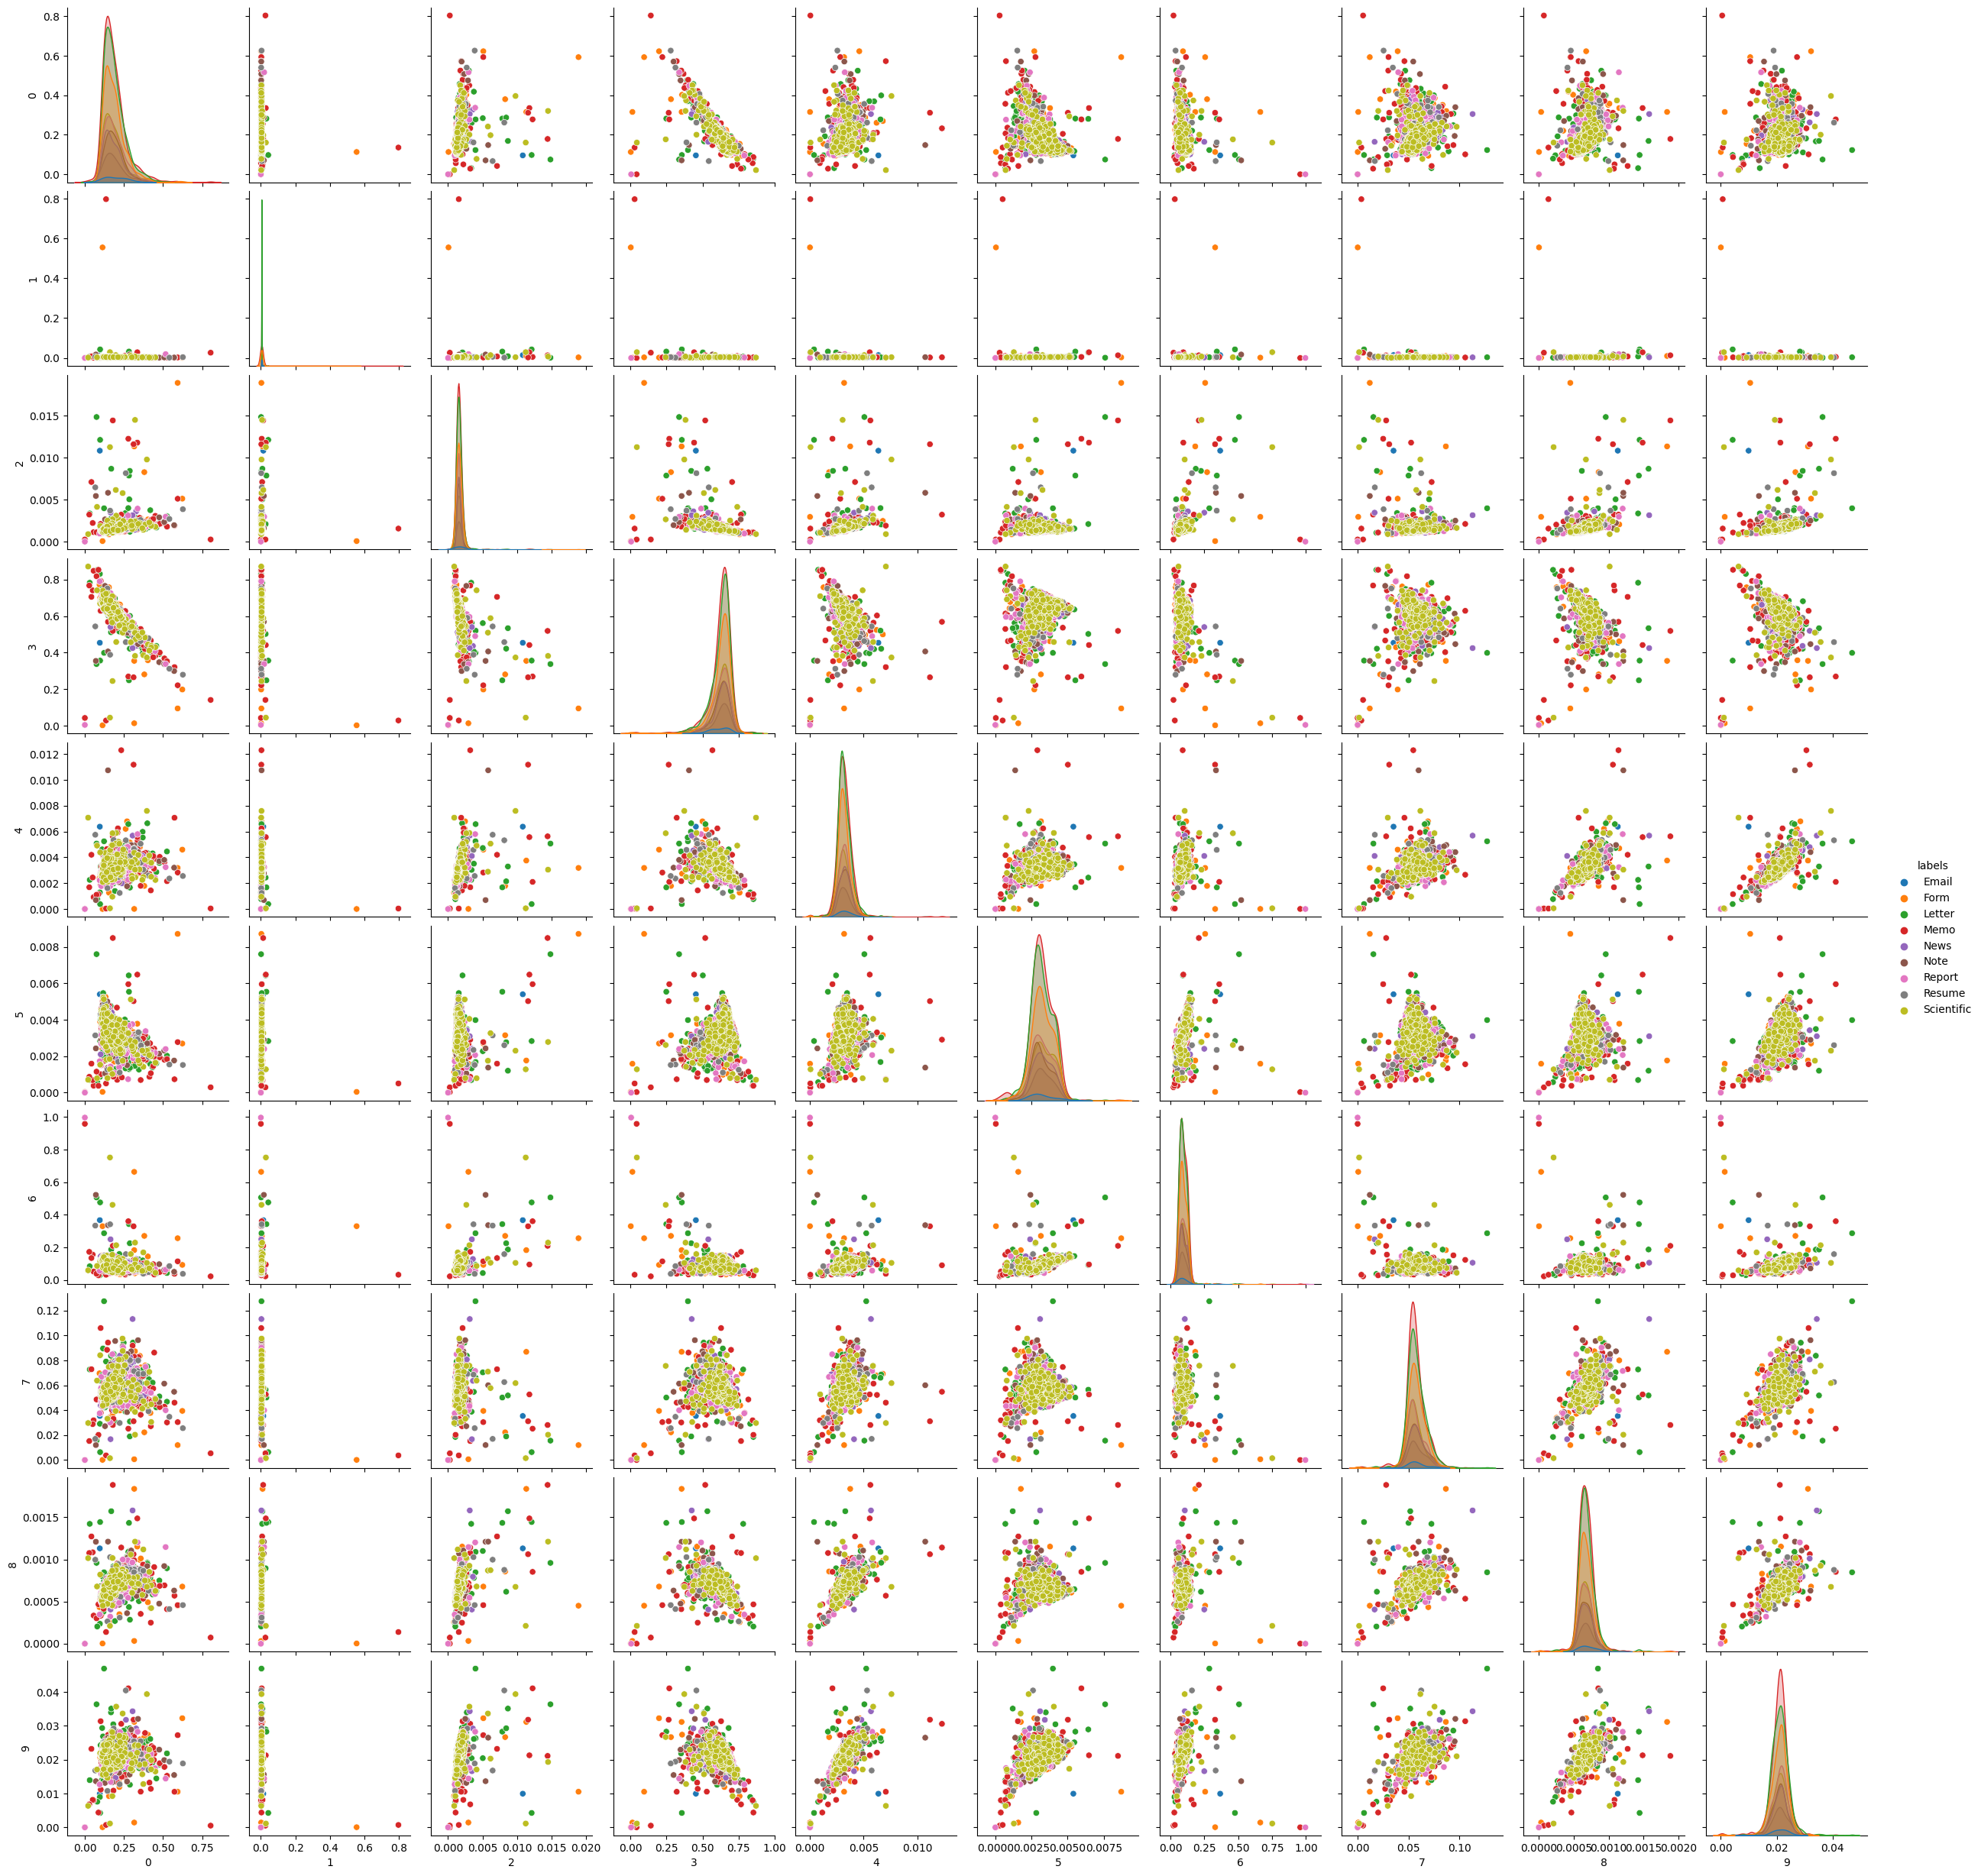

In [36]:
import seaborn as sns

sns.pairplot(DBfeatures, hue="labels")

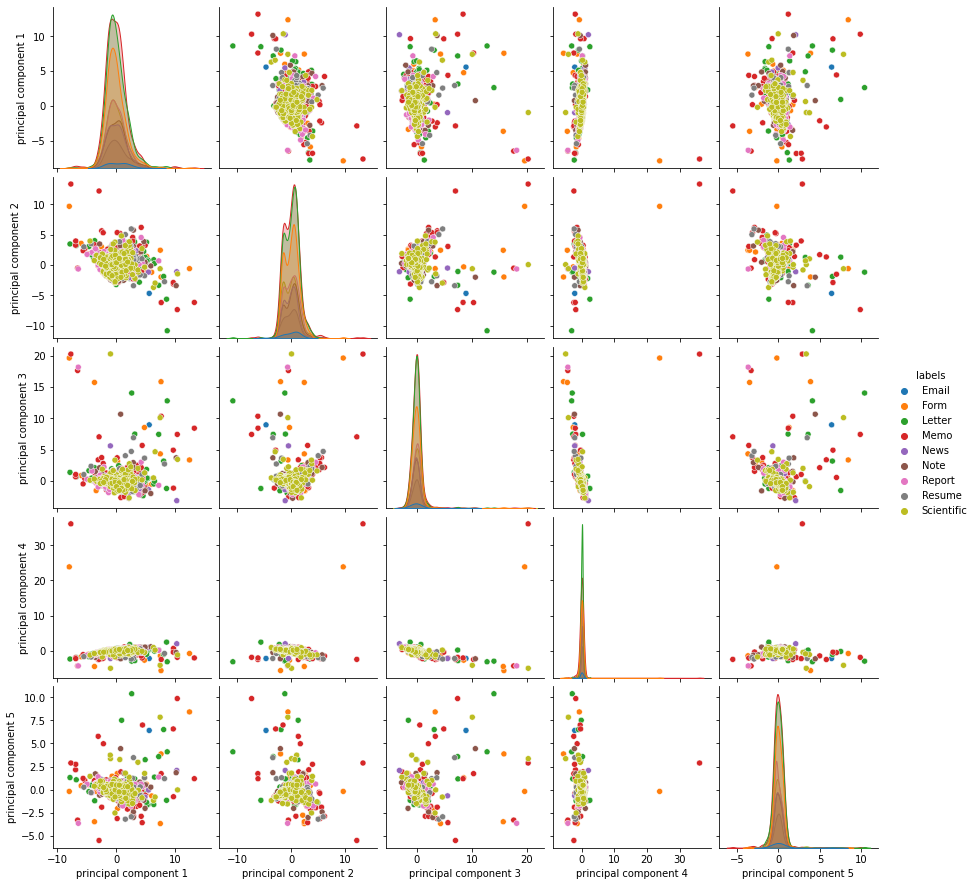

In [34]:
# Seaborn visualization library


sns.pairplot(principalDf, hue="labels")